# Run a gensim on Official Journal Data from 2018, 2019, 2020

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
from bs4 import BeautifulSoup as bs
import pandas as pd
import glob


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import data

In [3]:
filepaths = []
for filepath in glob.iglob(r'OJ_data/*/*', recursive=True ):
    print (filepath)
    filepaths.append(filepath)

OJ_data/2020/c_entries_20.csv
OJ_data/2020/l_entries_20.csv
OJ_data/2019/c_texts_2019.csv
OJ_data/2019/legislation_text_2019.csv
OJ_data/2018/c_entries_18.csv
OJ_data/2018/l_entries_18.csv


In [4]:
dfs = []
for file in filepaths:
    dfs.append(pd.read_csv(file))

In [5]:
big_df = pd.concat(dfs, ignore_index=True)

In [6]:
data = list(big_df['text'])

## Data clean

In [7]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

## Tokenize

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        gensim.parsing.preprocessing.strip_non_alphanum
        yield(gensim.utils.simple_preprocess(gensim.parsing.preprocessing.strip_non_alphanum(str(sentence)).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['official', 'journal', 'issn', 'official', 'journal', 'of', 'the', 'european', 'union', 'english', 'edition', 'information', 'and', 'notices', 'volume', 'january', 'contents', 'page', 'iv', 'notices', 'notices', 'from', 'european', 'union', 'institutions', 'bodies', 'offices', 'and', 'agencies', 'european', 'commission', 'euro', 'exchange', 'rates', 'december', 'euro', 'exchange', 'rates', 'december', 'euro', 'exchange', 'rates', 'january', 'announcements', 'procedures', 'relating', 'to', 'the', 'implementation', 'of', 'competition', 'policy', 'european', 'commission', 'prior', 'notification', 'of', 'concentration', 'case', 'astorg', 'nordic', 'capital', 'novo', 'ert', 'candidate', 'case', 'for', 'simplified', 'procedure', 'text', 'with', 'eea', 'relevance', 'en', 'iv', 'notices', 'notices', 'from', 'european', 'union', 'institutions', 'bodies', 'offices', 'and', 'agencies', 'european', 'commission', 'en', 'official', 'journal', 'of', 'the', 'european', 'union', 'euro', 'exchange', '

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['official', 'journal', 'issn', 'official', 'journal', 'of', 'the', 'european', 'union', 'english_edition', 'information', 'and', 'notices_volume', 'january', 'contents_page', 'iv_notices_notices', 'from', 'european', 'union', 'institutions_bodies_offices', 'and', 'agencies', 'european', 'commission', 'euro', 'exchange', 'rates', 'december', 'euro', 'exchange', 'rates', 'december', 'euro', 'exchange', 'rates', 'january', 'announcements_procedures_relating', 'to', 'the', 'implementation', 'of', 'competition', 'policy', 'european', 'commission', 'prior', 'notification', 'of', 'concentration', 'case', 'astorg', 'nordic', 'capital', 'novo', 'ert', 'candidate', 'case', 'for', 'simplified', 'procedure', 'text', 'with', 'eea_relevance', 'en', 'iv_notices_notices', 'from', 'european', 'union', 'institutions_bodies_offices', 'and', 'agencies', 'european', 'commission', 'en', 'official', 'journal', 'of', 'the', 'european', 'union', 'euro', 'exchange', 'rates', 'december', 'euro', 'currency', 'ex

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 3000000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['official', 'official', 'notice', 'volume', 'contents_page', 'institution', 'bodies_office', 'agencie', 'exchange', 'rate', 'exchange', 'rate', 'exchange', 'rate', 'announcements_procedure', 'relate', 'implementation', 'competition', 'policy', 'case', 'nordic', 'capital', 'candidate', 'case', 'simplify', 'procedure', 'text', 'institution', 'bodies_office', 'agencie', 'official', 'exchange', 'rate', 'danish_krone', 'gbp_pound', 'sterling_sek', 'swedish_krona', 'iceland_krona', 'hungarian_forint', 'try_turkish', 'singapore_dollar', 'african_rand', 'yuan_renminbi', 'ringgit_php', 'philippine_peso', 'thai_baht', 'rupee_source', 'reference', 'exchange', 'rate', 'publish', 'official', 'exchange', 'rate', 'danish_krone', 'gbp_pound', 'sterling_sek', 'swedish_krona', 'iceland_krona', 'hungarian_forint', 'try_turkish', 'singapore_dollar', 'african_rand', 'yuan_renminbi', 'ringgit_php', 'philippine_peso', 'thai_baht', 'rupee_source', 'reference', 'exchange', 'rate', 'publish', 'official', 'exc

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 2), (15, 3), (16, 7), (17, 5), (18, 1), (19, 1), (20, 4), (21, 1), (22, 2), (23, 2), (24, 2), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 3), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 9), (43, 1), (44, 1), (45, 2), (46, 1), (47, 3), (48, 1), (49, 1), (50, 3), (51, 1), (52, 1), (53, 1), (54, 3), (55, 3), (56, 2), (57, 1), (58, 1), (59, 1), (60, 2), (61, 2), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 3), (75, 1), (76, 1), (77, 1), (78, 6), (79, 1), (80, 2), (81, 2), (82, 1), (83, 3), (84, 6), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 2), (95, 4), (96, 1), (97, 2), (98, 1), (99, 1), (100, 3), (101, 1), (102, 2), (103, 9), (104, 1), (105, 1), (106, 4), (107, 4), (108, 2), (109, 1), (110, 2)

In [13]:
id2word[0]

'accomplish'

In [14]:
corpus[:1][0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 3),
 (4, 2),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1)]

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accomplish', 1),
  ('acquire', 1),
  ('activity', 1),
  ('african_rand', 3),
  ('agencie', 2),
  ('always', 1),
  ('announcements_procedure', 2),
  ('area', 1),
  ('array', 1),
  ('article', 1),
  ('asset', 1),
  ('belgique_belgie', 1),
  ('bodies_office', 2),
  ('broad', 2),
  ('business', 2),
  ('candidate', 3),
  ('capital', 7),
  ('case', 5),
  ('certain', 1),
  ('clinical', 1),
  ('commission', 4),
  ('company', 1),
  ('competition', 2),
  ('concentration', 2),
  ('concern', 2),
  ('consumer', 1),
  ('contact_detail', 1),
  ('contents_page', 1),
  ('control', 3),
  ('current', 1),
  ('currently', 1),
  ('danish_krone', 3),
  ('date', 1),
  ('day', 1),
  ('decision', 1),
  ('dedicate', 1),
  ('ecb', 1),
  ('email', 1),
  ('email_comp', 1),
  ('enable', 1),
  ('equity', 2),
  ('ert', 1),
  ('exchange', 9),
  ('fall', 1),
  ('final', 1),
  ('financial', 2),
  ('find', 1),
  ('follow', 3),
  ('foundation', 1),
  ('fund', 1),
  ('gbp_pound', 3),
  ('group', 1),
  ('healthcare', 1),

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"service" + 0.018*"information" + 0.018*"datum" + 0.016*"member" + '
  '0.011*"authority" + 0.010*"provide" + 0.009*"include" + 0.009*"access" + '
  '0.009*"state" + 0.009*"national"'),
 (1,
  '0.021*"state" + 0.019*"service" + 0.019*"market" + 0.017*"aid" + '
  '0.014*"measure" + 0.010*"grant" + 0.010*"authority" + 0.010*"decision" + '
  '0.010*"cost" + 0.009*"tax"'),
 (2,
  '0.023*"contain" + 0.019*"product" + 0.019*"weight" + 0.018*"material" + '
  '0.015*"use" + 0.013*"head" + 0.012*"less" + 0.012*"article" + '
  '0.011*"similar" + 0.011*"manufacture"'),
 (3,
  '0.131*"code" + 0.093*"name" + 0.073*"incl" + 0.069*"number" + 0.064*"date" '
  '+ 0.054*"type" + 0.033*"text" + 0.021*"government" + 0.020*"me" + '
  '0.020*"decision"'),
 (4,
  '0.018*"member" + 0.017*"state" + 0.013*"call" + 0.010*"right" + '
  '0.008*"include" + 0.008*"regard" + 0.007*"support" + 0.007*"text" + '
  '0.006*"amendment" + 0.006*"country"'),
 (5,
  '0.028*"financial" + 0.020*"year" + 0.015*"bud

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.296526979472523

Coherence Score:  0.508833458646896


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Calculating the ideal number of topics
Set the initial limit to 80

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=80, step=6)

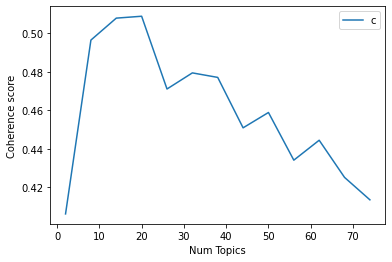

In [22]:
# Show graph
limit=80; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4062
Num Topics = 8  has Coherence Value of 0.4965
Num Topics = 14  has Coherence Value of 0.5079
Num Topics = 20  has Coherence Value of 0.5088
Num Topics = 26  has Coherence Value of 0.4711
Num Topics = 32  has Coherence Value of 0.4794
Num Topics = 38  has Coherence Value of 0.4771
Num Topics = 44  has Coherence Value of 0.4509
Num Topics = 50  has Coherence Value of 0.4589
Num Topics = 56  has Coherence Value of 0.4341
Num Topics = 62  has Coherence Value of 0.4444
Num Topics = 68  has Coherence Value of 0.4251
Num Topics = 74  has Coherence Value of 0.4135


In [26]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"service" + 0.018*"information" + 0.018*"datum" + 0.016*"member" + '
  '0.011*"authority" + 0.010*"provide" + 0.009*"include" + 0.009*"access" + '
  '0.009*"state" + 0.009*"national"'),
 (1,
  '0.021*"state" + 0.019*"service" + 0.019*"market" + 0.017*"aid" + '
  '0.014*"measure" + 0.010*"grant" + 0.010*"authority" + 0.010*"decision" + '
  '0.010*"cost" + 0.009*"tax"'),
 (2,
  '0.023*"contain" + 0.019*"product" + 0.019*"weight" + 0.018*"material" + '
  '0.015*"use" + 0.013*"head" + 0.012*"less" + 0.012*"article" + '
  '0.011*"similar" + 0.011*"manufacture"'),
 (3,
  '0.131*"code" + 0.093*"name" + 0.073*"incl" + 0.069*"number" + 0.064*"date" '
  '+ 0.054*"type" + 0.033*"text" + 0.021*"government" + 0.020*"me" + '
  '0.020*"decision"'),
 (4,
  '0.018*"member" + 0.017*"state" + 0.013*"call" + 0.010*"right" + '
  '0.008*"include" + 0.008*"regard" + 0.007*"support" + 0.007*"text" + '
  '0.006*"amendment" + 0.006*"country"'),
 (5,
  '0.028*"financial" + 0.020*"year" + 0.015*"bud

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        #row = sorted(row, key=lambda x: (x[0]), reverse=True)
        topics = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        #print(f"topics {topics}")
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == topics[0][0]:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                continue
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8049,"service, information, datum, member, authority...",Official Journal C 1/2020 ISSN 1977-091X Offi...
1,1,3.0,0.1516,"code, name, incl, number, date, type, text, go...",Official Journal C 2/2020 ISSN 1977-091X Offi...
2,2,0.0,0.0229,"service, information, datum, member, authority...",Official Journal C 3/2020 ISSN 1977-091X Offi...
3,3,0.0,0.0451,"service, information, datum, member, authority...",Official Journal C 3A/2020 ISSN 1977-091X Off...
4,4,9.0,0.0532,"wine, origin, protected_designation, product, ...",Official Journal C 4/2020 ISSN 1977-091X Offi...
5,5,0.0,0.2497,"service, information, datum, member, authority...",Official Journal C 5/2020 ISSN 1977-091X Offi...
6,6,3.0,0.2772,"code, name, incl, number, date, type, text, go...",Official Journal C 6/2020 ISSN 1977-091X Offi...
7,7,3.0,0.0144,"code, name, incl, number, date, type, text, go...",Official Journal C 7/2020 ISSN 1977-091X Offi...
8,8,6.0,0.0107,"vote, rule, resolution, follow, committee, gro...",Official Journal C 8/2020 ISSN 1977-091X Offi...
9,9,3.0,0.2530,"code, name, incl, number, date, type, text, go...",Official Journal C 9/2020 ISSN 1977-091X Offi...


In [ ]:
# Visualize the optimal number of topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

In [29]:
df_dominant_topic.to_csv('data/dominant_topics_18-20.csv')

In [35]:
df_dominant_topic.count()

Document_No           2821
Dominant_Topic         857
Topic_Perc_Contrib     857
Keywords               857
Text                  2821
dtype: int64

In [52]:
df_dominant_topic.groupby(['Dominant_Topic'], dropna=False).Text.count().reset_index()

,Dominant_Topic,Text
0,0.0,364
1,1.0,32
2,2.0,21
3,3.0,110
4,4.0,23
5,5.0,23
6,6.0,8
7,7.0,24
8,9.0,16
9,11.0,42


In [55]:
int(857/2821 * 100)

30